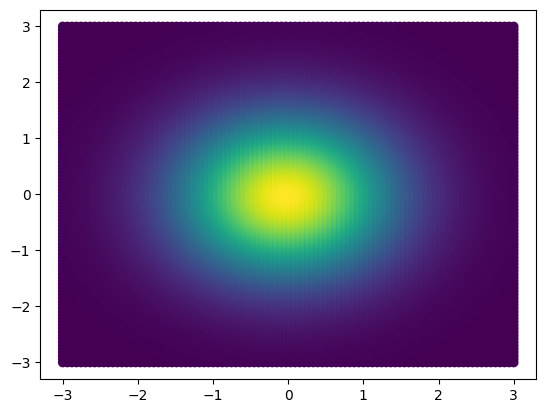

In [9]:
import torch
import matplotlib.pyplot as plt

## Data via Expression
dn = 100
range_xy = torch.linspace(start=-3,end=3,steps=dn)
gridx, gridy = torch.meshgrid(range_xy,range_xy)
datax = torch.flatten(gridx)
datay = torch.flatten(gridy)
z0 = torch.stack((datax,datay))

mu = torch.zeros((2,1))
sig = torch.eye(2)
isig = torch.linalg.inv(sig)
dsig = torch.linalg.det(sig)
A = torch.divide(1,2*torch.pi*torch.sqrt(dsig))
B = torch.matmul(torch.mul(torch.tensor([-0.5]),(z0-mu).T),torch.matmul(isig,z0-mu))
q0 = torch.diagonal(A*torch.exp(B))
ln_q0 = torch.log(q0)

## Data via Sampling
mu_func = torch.zeros((1,2))
sig_func = torch.eye(2)
q0_func = torch.distributions.multivariate_normal.MultivariateNormal(mu_func, sig_func)
z0_sample = torch.squeeze(q0_func.sample((100000,))).T

# Data via Expression
plt.figure(101)
plt.scatter(datax,datay,c=q0)
plt.xlim([-3,3])
plt.ylim([-3,3])

# Data via Sampling
plt.figure(102)
plt.hist2d(z0_sample[0,:],z0_sample[1,:], bins=50)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

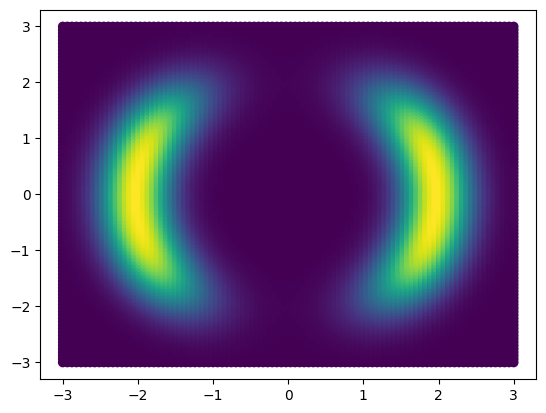

In [10]:
# Example Parameters
w = torch.Tensor([[5.0,0.0]])
b = torch.Tensor([0.0])
u = torch.Tensor([[1.0,0.0]])

# Jacobian Transformation
h = torch.tanh(torch.matmul(w,z0) + b)
hp = 1-torch.pow(h,2)
detJ = torch.abs(1 + torch.mul(torch.matmul(w,u.T),hp))
ln_q_z1 = torch.log(detJ)
z1_jac = z0 + torch.matmul(u.T,h)
q1_jac = torch.exp(ln_q0 - ln_q_z1)

# Sampling Transformation
h = torch.tanh(torch.matmul(w,z0_sample) + b)
z1_sam = z0_sample + torch.matmul(u.T,h)

# PDF via Jacobian
plt.figure(103)
plt.scatter(datax,datay,c=q1_jac)
plt.xlim([-3,3])
plt.ylim([-3,3])

# PDF via Sampling
plt.figure(104)
plt.hist2d(z1_sam[0,:],z1_sam[1,:], bins=50)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

In [ ]:
# Create Reference Output
data_norm = torch.sqrt(torch.pow(datax,2) + torch.pow(datay,2))
C1 = torch.mul(0.5,torch.pow(torch.div(data_norm - 2,0.4),2))
C2 = torch.mul(-0.5,torch.pow(torch.div(datax - 2,0.6),2))
C3 = torch.mul(-0.5,torch.pow(torch.div(datax + 2,0.6),2))
C4 = torch.logaddexp(C2,C3)
qn_ref = torch.reshape(torch.exp(-(C1 - C4)),(1,dn**2))
ln_qn_ref = torch.log(qn_ref)

# visualize output
plt.figure(105)
plt.scatter(datax,datay,c=qn_ref)
plt.xlim([-3,3])
plt.ylim([-3,3])

In [11]:
## Create Single Layer of Discrete Normalizing Flow
class Planar_Layer(torch.nn.Module):
    def __init__(self,d):
        super(Planar_Layer,self).__init__()
        self.u = torch.nn.Parameter(torch.Tensor(1, d), requires_grad=True)
        self.w = torch.nn.Parameter(torch.Tensor(1, d), requires_grad=True)
        self.b = torch.nn.Parameter(torch.Tensor(1), requires_grad=True)
        self.init_params()

    def init_params(self):
        self.w.data.uniform_(-0.01, 0.01)
        self.b.data.uniform_(-0.01, 0.01)
        self.u.data.uniform_(-0.01, 0.01)
        
    def forward(self, z):     
        h = torch.tanh(torch.matmul(self.w,z) + self.b)
        hp = 1-torch.pow(h,2)
        detJ = 1 + torch.mul(torch.matmul(self.w,self.u.T),hp)
        ln_q_zL = torch.log(torch.abs(detJ))
        zL = z + torch.matmul(self.u.T,h)
        
        return zL, ln_q_zL
    
## Create Discrete Normalizing Flows Class
class DNF(torch.nn.Module): # torch only tracks parameters with autograd when requires_grad=True
    def __init__(self,d,L):
        super(DNF,self).__init__()
        self.layers = torch.nn.ModuleList([Planar_Layer(d) for _ in range(L)])
        
    def forward(self, x: torch.Tensor) -> torch.Tensor: # forward is a required part, this defines what to do in the forward pass of the nn, automatically
        zL = x
        sigma_ln_q_zL = 0
               
        for layer in self.layers:
            zL, ln_q_zL = layer.forward(zL)
            sigma_ln_q_zL += ln_q_zL
            
        return zL, sigma_ln_q_zL

In [12]:
## Define NN Hyper-Parameters
d = 2        # dimension of input data
L = 8       # HYPERPARAMETER: number of sequencial layers
a = 0.0001   # HYPERPARAMETER: Learning Rate
theta = 0.9  # HYPERPARAMETER: Momentum Coefficient
e = 3000     # HYPERPARAMETER: Number of epochs
b = 100      # HYPERPARAMETER: batch size

model = DNF(d,L)

# loss_eval = torch.nn.KLDivLoss(reduction="batchmean")
loss_eval = torch.nn.MSELoss()

optimizer = torch.optim.RMSprop(params=model.parameters(),lr=a,momentum=theta)
loss_vec = torch.zeros((e,1))
model.train()                  # this command tells pytorch to track gradients

for i in range(e):
    zL, ln_q_zL = model(z0)        # do forward propogation
    ln_qn_pred = ln_q0 - ln_q_zL   # Compute log probability density after transformation
    
    # loss = loss_eval(ln_qn_pred,qn_ref)
    loss = loss_eval(torch.exp(ln_qn_pred),qn_ref)
    loss_vec[i] = loss.data
    
    optimizer.zero_grad()     # zero out gradients for all model parameters, value is accumulated not replaced!
    loss.backward()           # update gradients for each model parameter 
    optimizer.step()          # update each model parameter using gradient descent  

model.eval()

Number of parameters in the model: 160


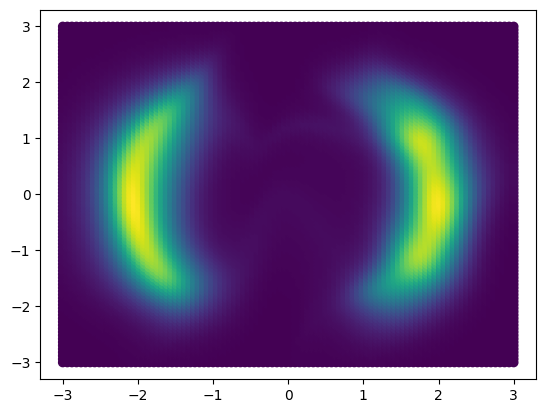

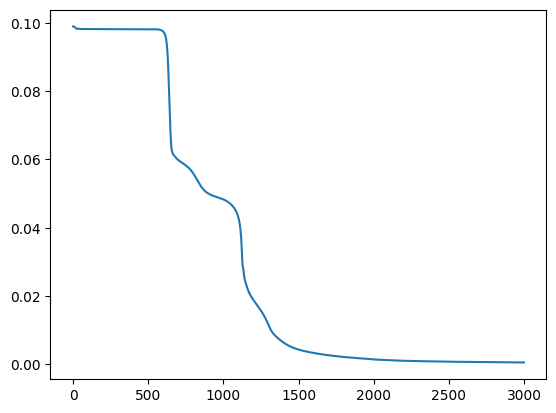

In [17]:
## Evaluation 1: PDF
plt.figure(106)
plt.scatter(z0[0,:].detach().numpy(),z0[1,:].detach().numpy(),c=torch.exp(ln_qn_pred).detach().numpy())
plt.ylim(-3,3)
plt.xlim(-3,3)

plt.figure(107)
plt.plot(range(e),loss_vec.data)

print(loss_vec[-1])

In [ ]:
## Evaluation #2: Point Flow
zL, ln_q_zL = model(z0_sample)

plt.figure(108)
plt.hist2d(zL[0,:].detach().numpy(),zL[1,:].detach().numpy(), bins=50)

plt.show()